# Brain Tumor Sementation

### Library Imports

In [4]:
import numpy as np
import os
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nibabel as nib

In [5]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import backend as K 
from keras import Input, Model
from keras.layers import MaxPooling2D, Conv2D, Conv2DTranspose, concatenate

In [6]:
# neural imaging
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib

### Metrics

In [7]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# soft dice loss 
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 

    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics = [f1_score, specificity, sensitivity, iou, soft_dice_loss, dice_coef, dice_coef_loss ]

### Configurations in Training Process

In [8]:
epochs = 10

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = CSVLogger('Model.log')

callbacks = [earlystop, csv_logger, reduce_lr]

### Mask area details

In [9]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

### Data Set Loading and Sample Visualization

In [9]:
import tarfile

file = tarfile.open('./dataset/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t2.nii.gz']

In [10]:
TRAIN_DATASET_PATH = './dataset/BraTS2021_Training_Data/'

In [11]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_t2.nii.gz']

In [12]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00066/BraTS2021_00066_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00066/BraTS2021_00066_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00066/BraTS2021_00066_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00066/BraTS2021_00066_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00066/BraTS2021_00066_seg.nii.gz').get_fdata()
test_image_t1.shape

(240, 240, 155)

Text(0.5, 1.0, 'Mask')

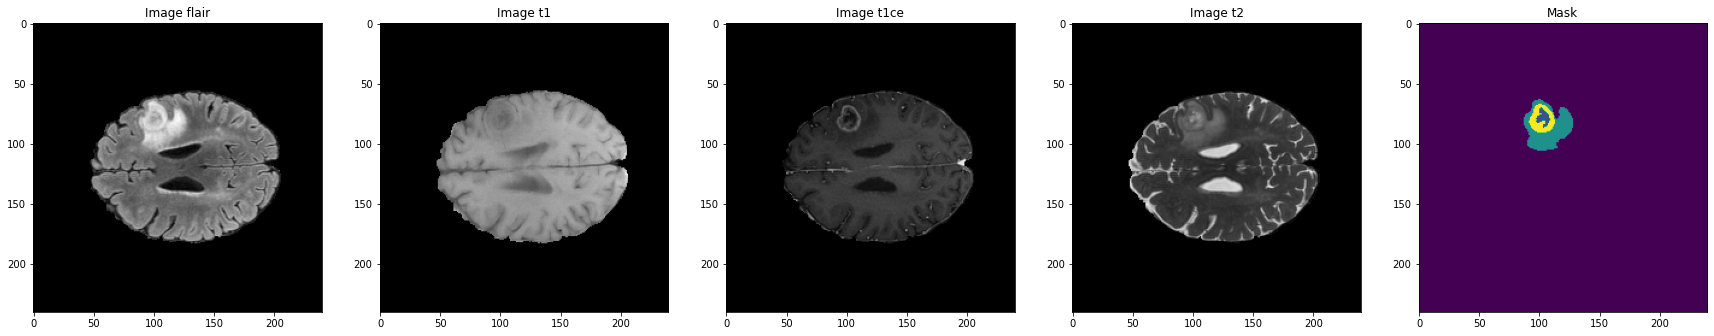

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (30, 30))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

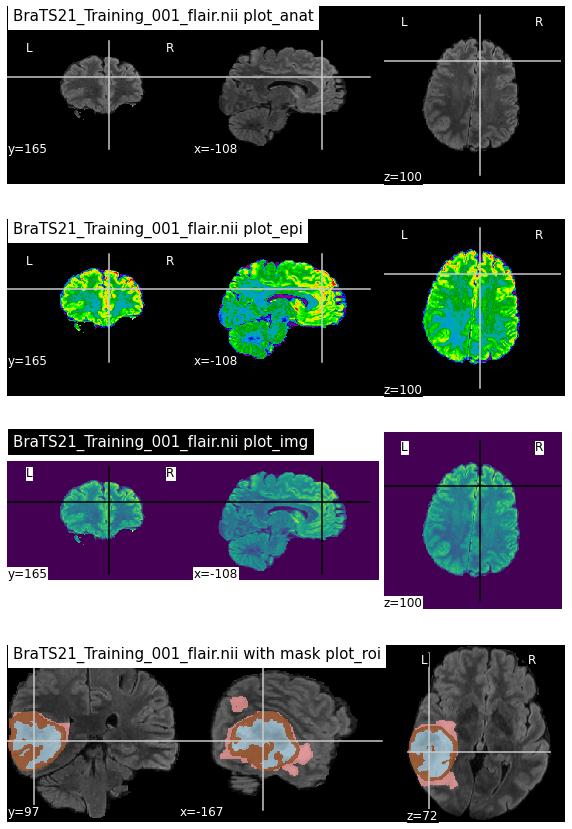

In [14]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00505/BraTS2021_00505_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_00505/BraTS2021_00505_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(10, 15))


nlplt.plot_anat(niimg,
                title='BraTS21_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS21_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS21_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS21_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

### Training and testind data split

In [11]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); # length = 1251

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) # length = 1000, 251
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) # length = 850, 150

### Custom Data Generator for Keras Model training and Prediction

In [12]:
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

class DataGenerator(tf.keras.utils.Sequence): # tf.keras.utils.Sequence is a template we can edit to make our own custom generator
                                                    # because we are using 3D data, we need to edit the __getitem__ function
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                
        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)
len(training_generator), len(valid_generator), len(test_generator)

(850, 251, 150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


850
251
150


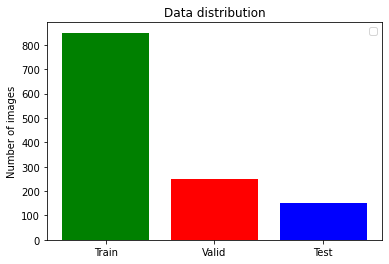

In [17]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
showDataLayout()

## Model Building

In [13]:
def conv_block(inputs, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def encoder_block(inputs, filters, kernel_size=3):
    x = conv_block(inputs, filters, kernel_size)
    x = conv_block(inputs, filters, kernel_size)
    #x = tf.keras.layers.Dropout(0.3)
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x, skip_connection


def decoder_block(inputs, skip_connection, filters, kernel_size=3):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2))(inputs)
    x = concatenate([x, skip_connection], axis=3)
    x = conv_block(x, filters, kernel_size)
    return x

In [14]:
def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    enc1, skip1 = encoder_block(inputs, 16)
    enc2, skip2 = encoder_block(enc1, 32)
    enc3, skip3 = encoder_block(enc2, 64)


    # Bridge
    bridge = conv_block(enc3, 128)
    

    # Decoder
    dec3 = decoder_block(bridge, skip3, 64)
    dec2 = decoder_block(dec3, skip2, 32)
    dec1 = decoder_block(dec2, skip1, 16)
    
    
    # Output
    output = Conv2D(4, 1, activation="softmax")(dec1)

    model = Model(inputs = inputs, outputs = output)
    return model

### Prepare the backend to train the model

In [15]:
K.clear_session()
# Create the U-Net++ model
input_shape = (128, 128, 2)  # Adjust the number of channels according to the data
model = build_model(input_shape)
model.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
            metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes = 4),tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='AUC'),
                       f1_score, specificity, sensitivity, iou, dice_coef, dice_coef_loss ] )

print(model.input_shape)
print(model.output_shape)
#model.summary()

(None, 128, 128, 2)
(None, 128, 128, 4)


### Model Training

In [ ]:
%%time
history =  model.fit(training_generator,
                        batch_size = 16,
                        epochs = 1,
                        verbose="auto",
                        steps_per_epoch=len(train_ids),
                        callbacks = callbacks ,
                        validation_data = valid_generator) 

### Model saving

In [28]:
model.save("UNet++.h5")
print('Model save to Disk')

c:\Users\askan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model save to Disk


### Model history saving

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_csv("output1.csv")
df.head(20)

## Model Evaluation

### Import the saved model

In [16]:
# Define a custom_objects dictionary to specify the custom metric
custom_objects = {'f1_score': f1_score, 'specificity': specificity, 'sensitivity': sensitivity, 'iou': iou, 'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}

# Load the model using custom_objects
model = keras.models.load_model('UNet++.h5', custom_objects=custom_objects)

### Model Architecture

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 16)         304       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 128, 128, 16)         64        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_2 (Activation)   (None, 128, 128, 16)         0         ['batch_normalization_5[0]

### Ground Truth data generation

In [16]:
# Calculate the total number of samples in the test dataset
num_samples_test = len(test_generator)

# Initialize arrays to store the ground truth data
ground_truth_data = []

# Iterate through the generator to collect the ground truth data
for batch_index in range(num_samples_test):
    X_batch, Y_batch = test_generator[batch_index]
    # Here, X_batch contains the test data, and Y_batch contains the ground truth data (masks)

    # Append Y_batch to the ground_truth_data list
    ground_truth_data.append(Y_batch)

# Convert the ground_truth_data list to a NumPy array
ground_truth_data = np.array(ground_truth_data)

### Model Prediction

In [20]:
y_predict = model.predict(test_generator, verbose=1)

150/150 [==============================] - 757s 5s/step


In [ ]:
ground_truth_data = np.concatenate(ground_truth_data, axis=0)
print(len(ground_truth_data), ground_truth_data.shape)
print(len(y_predict), y_predict.shape)

### Metrics Calculation

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss
dice = dice_coef(ground_truth_data, y_predict)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
dice_loss = dice_coef_loss(ground_truth_data, y_predict)

# soft dice loss 
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 

    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch
soft_dice = soft_dice_loss(ground_truth_data, y_predict)

#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
IOU = iou(ground_truth_data, y_predict)

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
Sensitivity = sensitivity(ground_truth_data, y_predict)

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
Specificity = specificity(ground_truth_data, y_predict)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
f1 = f1_score(ground_truth_data, y_predict)

In [ ]:
print("F1-Score:", float(f1.numpy()))
print("Sensitivity:", float(Sensitivity.numpy()))
print("Specificity:", float(Specificity.numpy()))
print("IOU:", float(IOU.numpy()))
print("Dice-Coefficient:", float(dice.numpy()))
print("Dice-Coefficient loss:", float(dice_loss.numpy()))
print("Soft-Dice loss:", soft_dice)

### Model layers plotting

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# 103 Layers

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model plotting

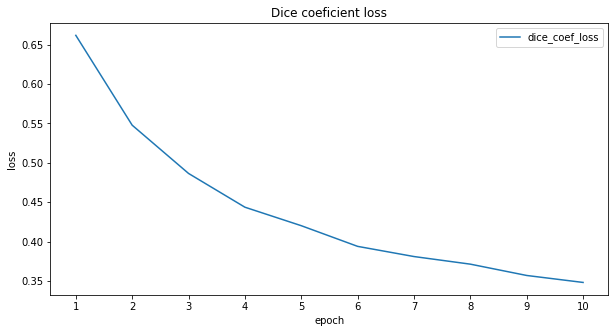

In [35]:
# reading the csv file
df = pd.read_csv('metrics.csv')
dice_coef_loss = df['dice_coef_loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(dice_coef_loss) + 1)
ax.plot(x_values, dice_coef_loss, label='dice_coef_loss')
ax.set_xticks(np.arange(1, 11))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Dice coeficient loss')
ax.legend()
plt.show()

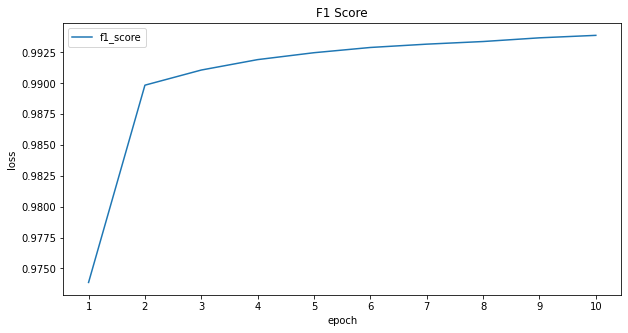

In [37]:
# reading the csv file
df = pd.read_csv('metrics.csv')
f1_score = df['f1_score']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(f1_score) + 1)
ax.plot(x_values, f1_score, label='f1_score')
ax.set_xticks(np.arange(1, 11))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('F1 Score')
ax.legend()
plt.show()

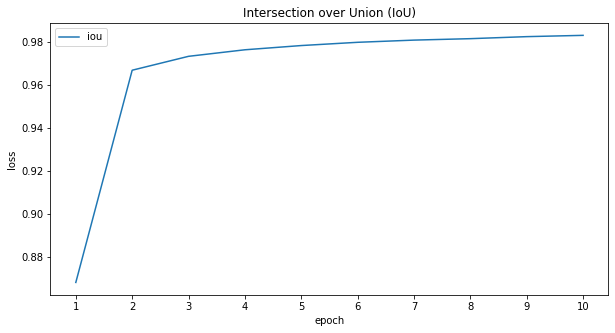

In [38]:
# reading the csv file
df = pd.read_csv('metrics.csv')
iou = df['iou']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(iou) + 1)
ax.plot(x_values, iou, label='iou')
ax.set_xticks(np.arange(1, 11))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Intersection over Union (IoU)')
ax.legend()
plt.show()